In [1]:
from dataset import PairedDatasetDouble
pd = PairedDatasetDouble('In/0', 'In/1', 'Out_New', 200)

Length of x_train 0 files: 943
Length of x_train 1 files: 943
Length of y_train files: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 

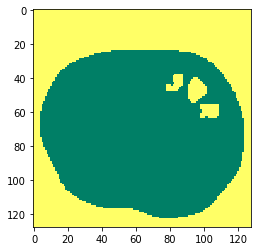

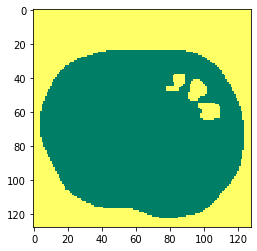

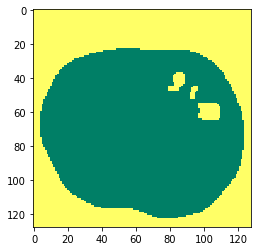

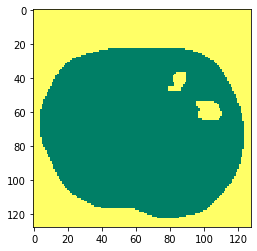

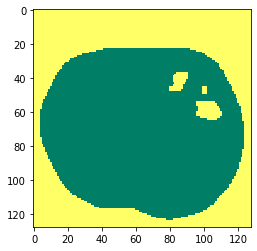

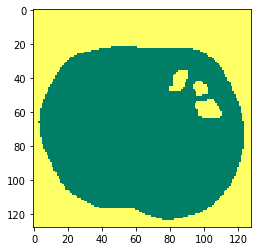

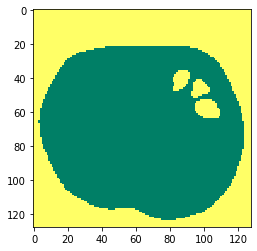

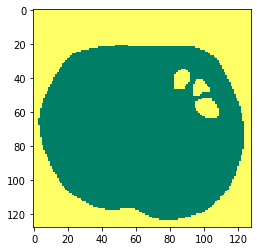

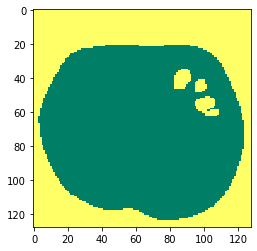

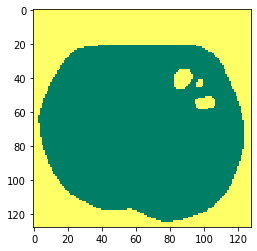

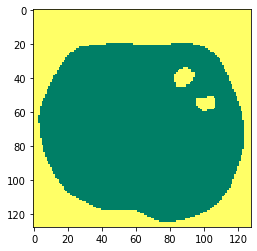

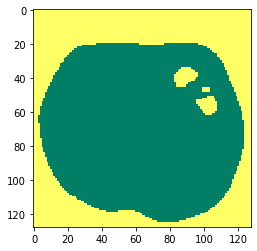

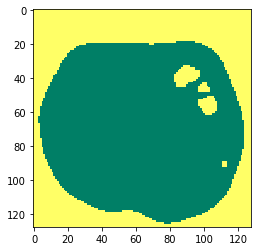

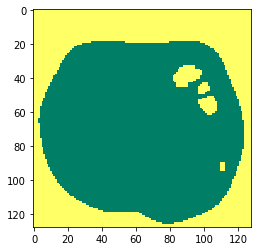

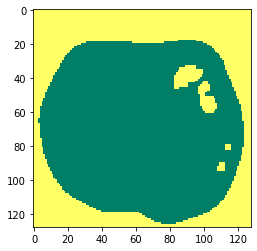

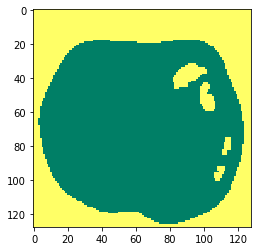

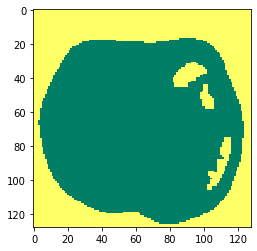

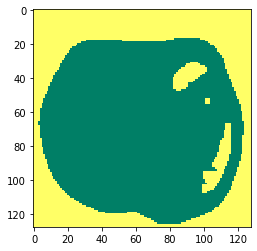

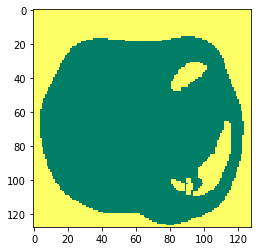

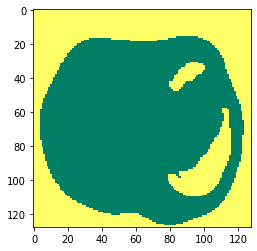

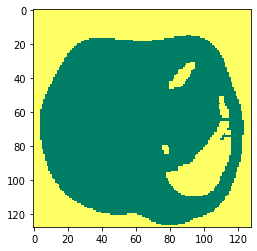

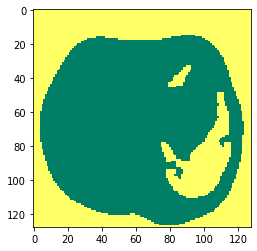

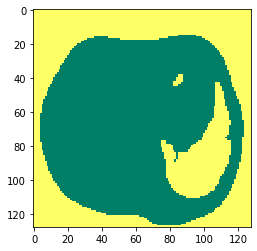

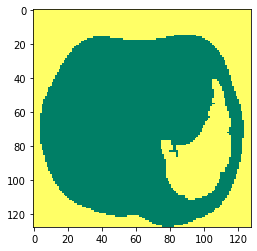

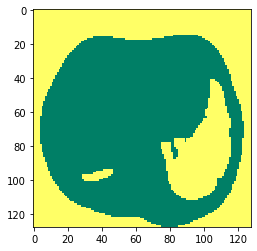

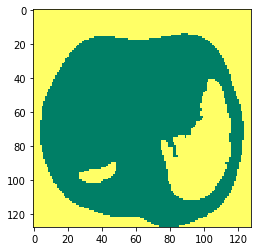

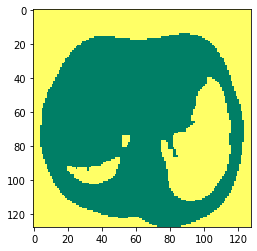

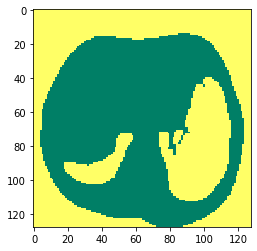

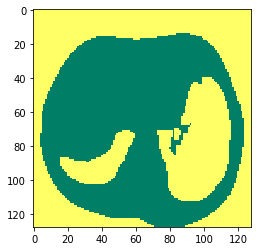

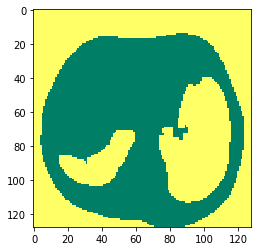

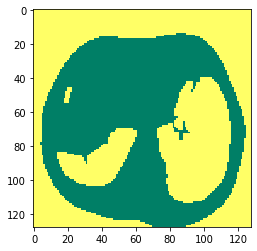

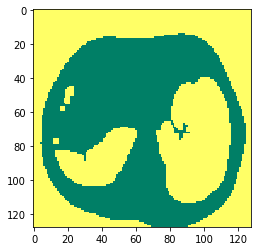

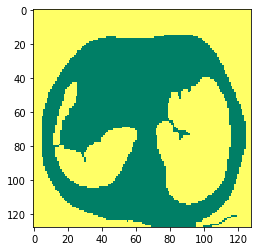

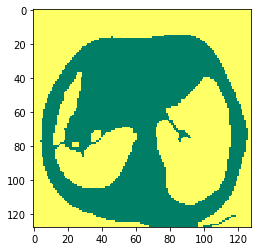

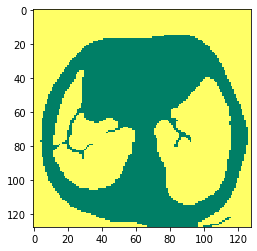

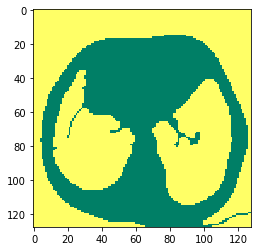

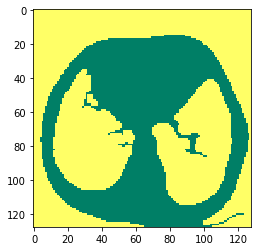

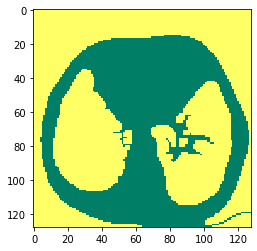

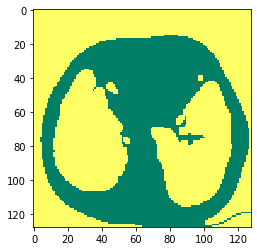

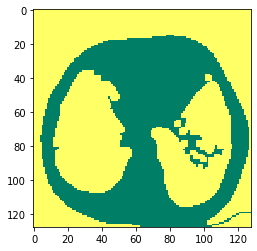

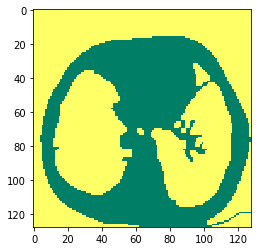

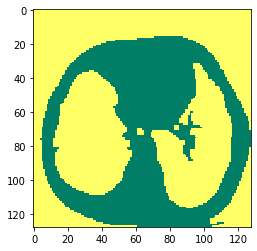

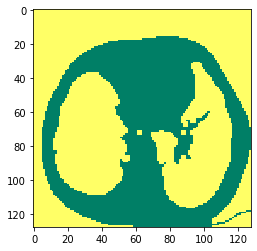

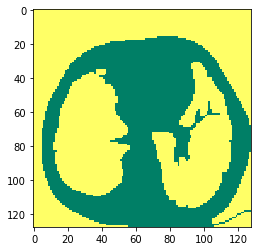

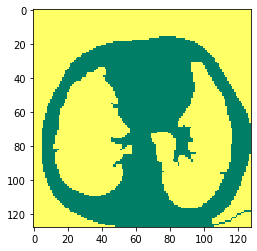

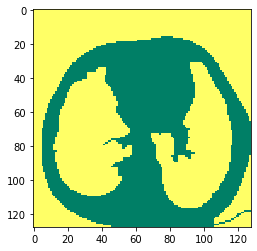

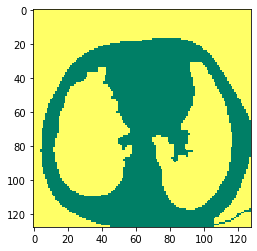

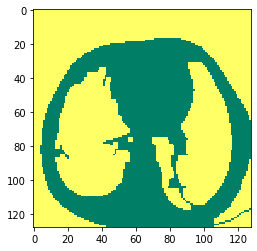

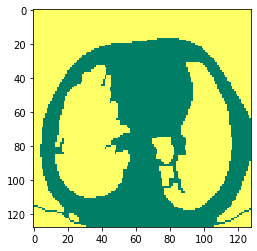

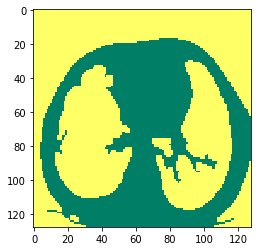

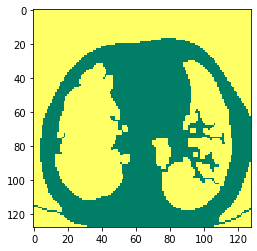

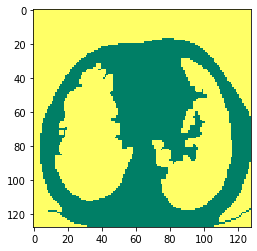

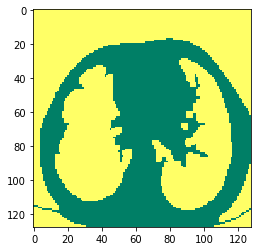

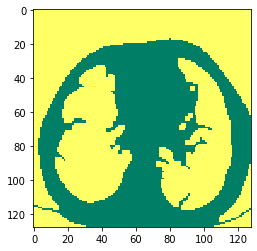

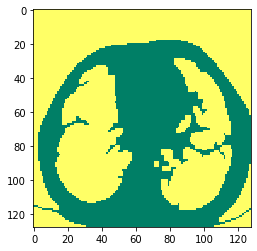

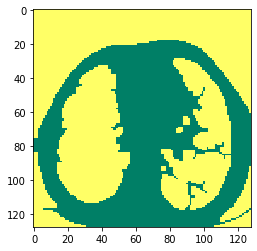

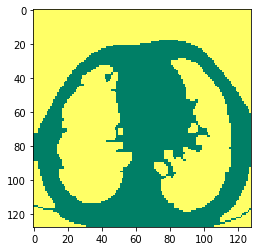

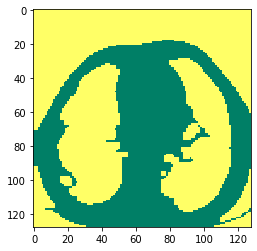

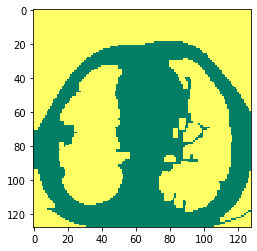

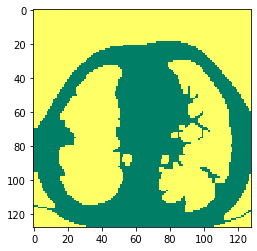

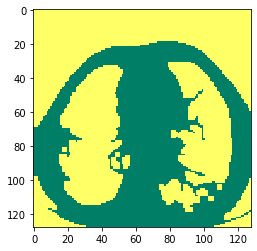

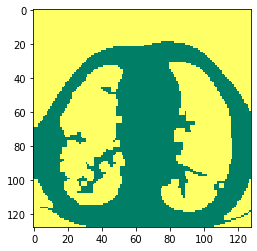

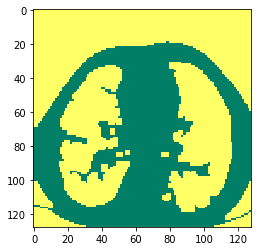

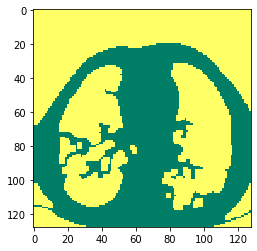

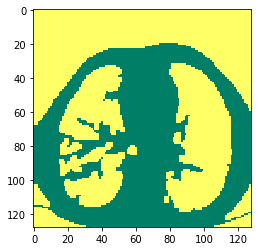

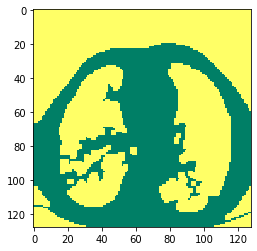

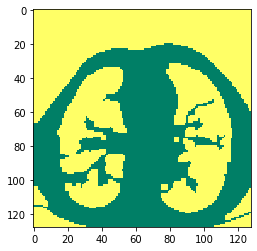

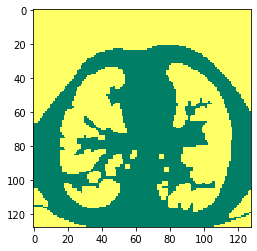

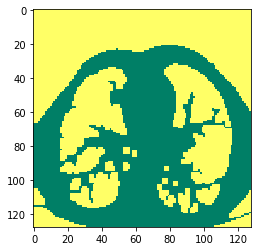

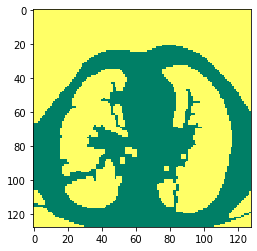

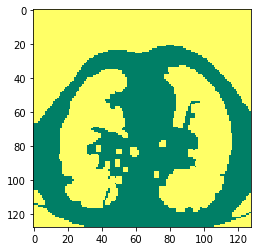

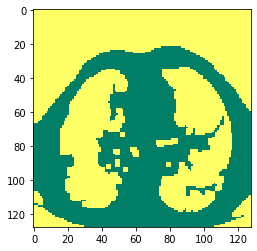

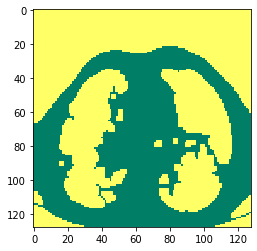

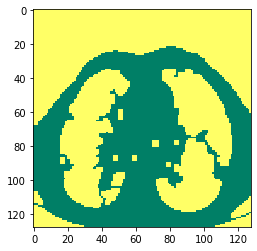

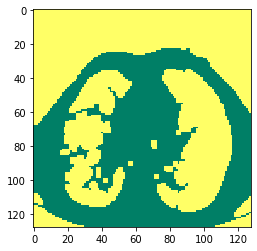

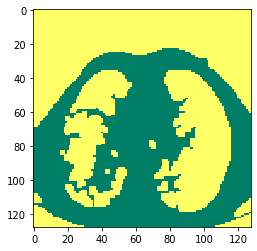

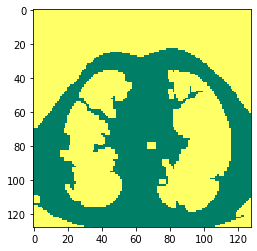

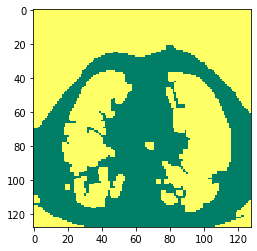

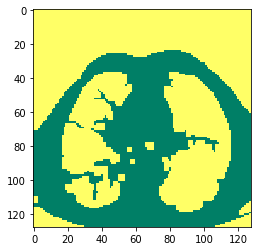

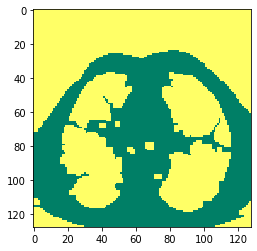

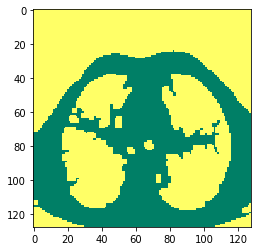

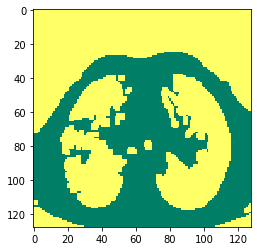

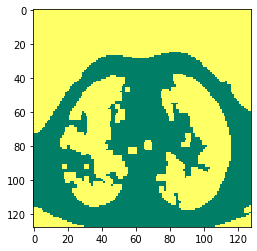

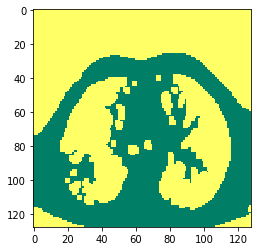

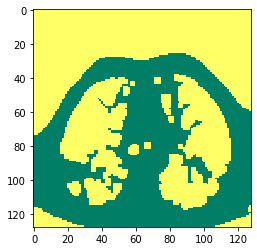

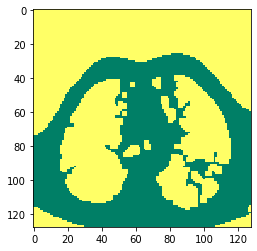

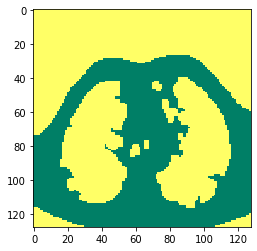

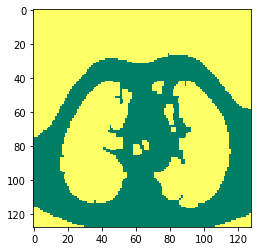

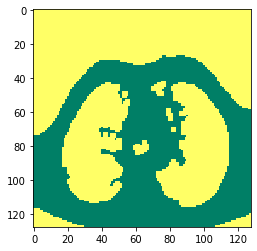

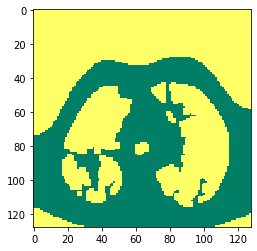

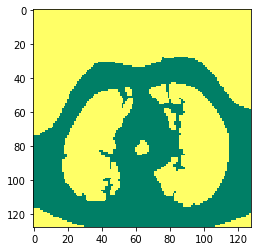

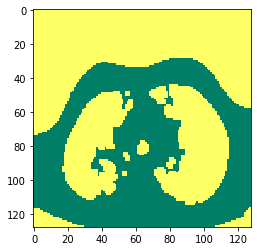

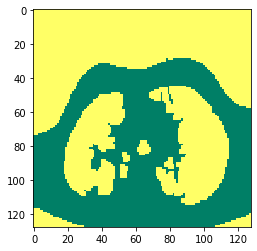

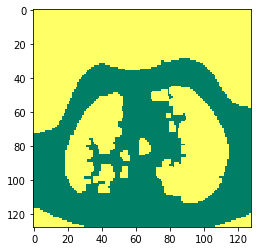

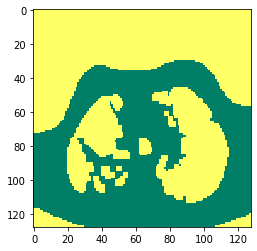

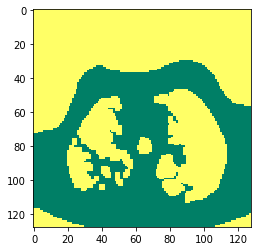

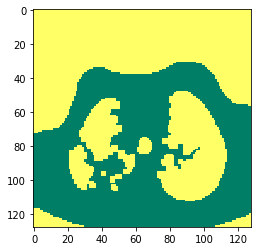

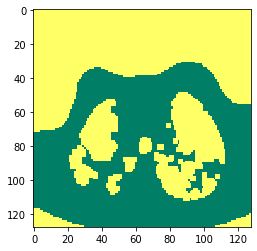

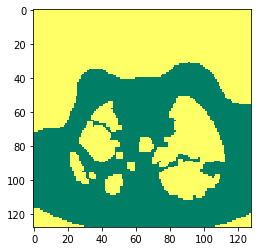

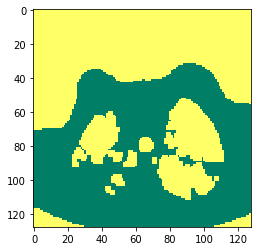

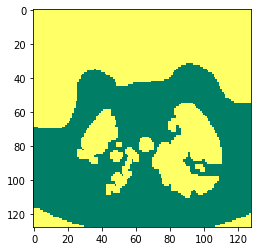

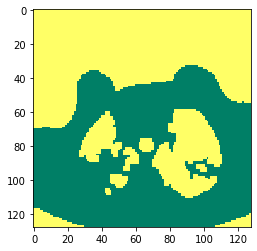

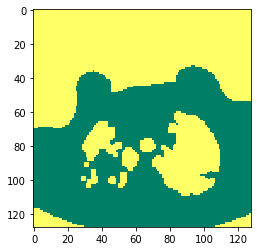

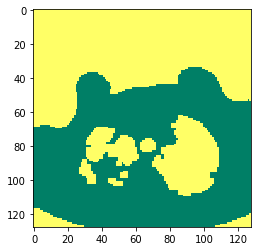

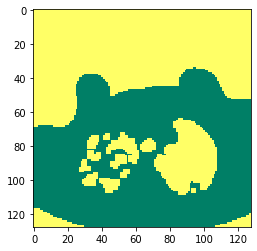

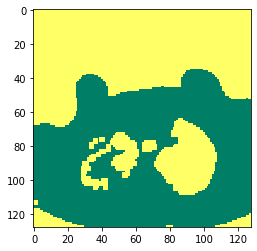

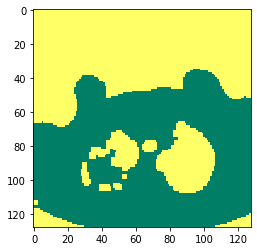

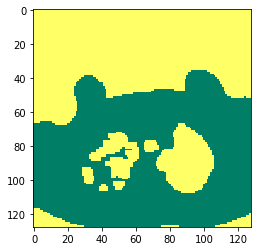

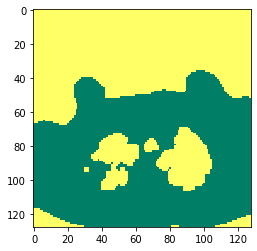

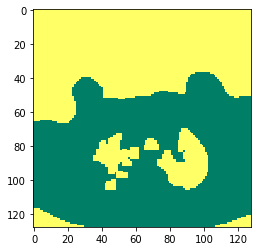

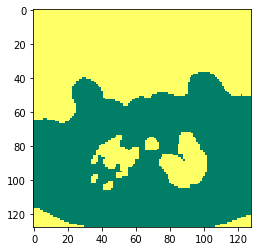

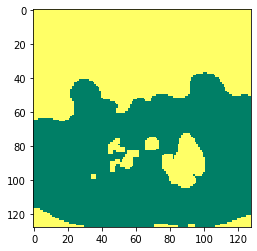

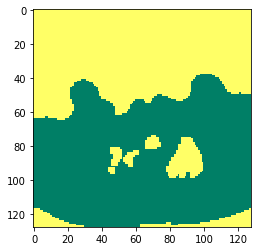

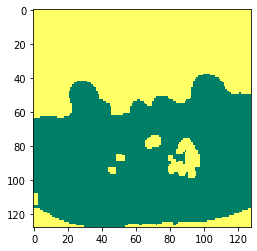

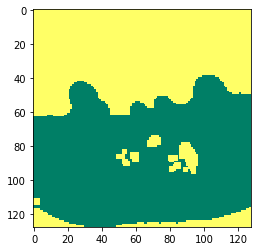

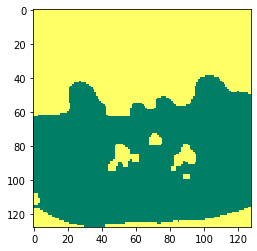

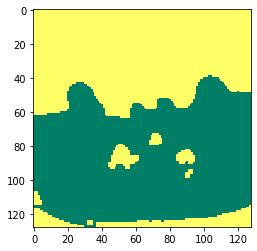

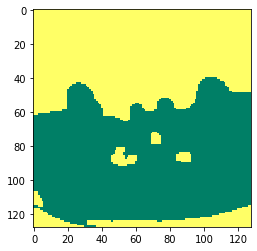

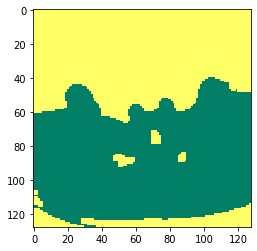

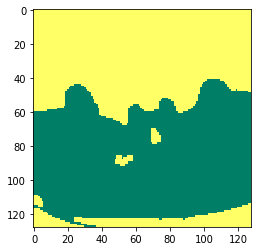

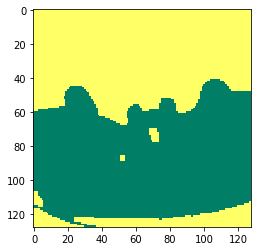

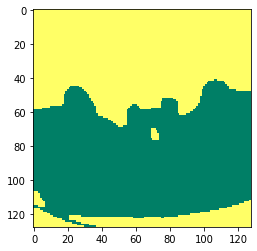

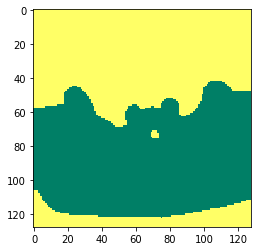

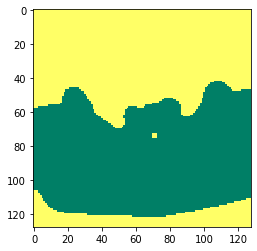

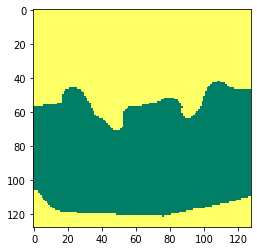

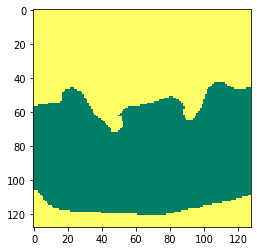

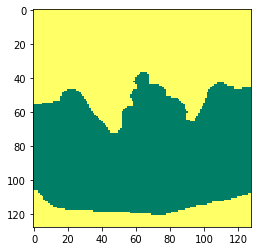

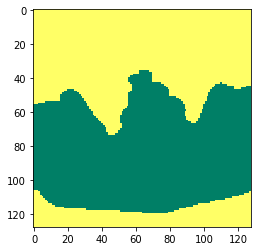

(128, 128, 128)


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy.ma as ma

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.05, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def erodilate(val, kernel, iterate):
    img_erosion = cv.erode(val, np.ones((kernel, kernel), np.uint8), iterations = iterate)
    img_errdil = cv.dilate(np.array(img_erosion), np.ones((kernel, kernel), np.uint8), iterations = iterate)
    return img_errdil

sample = pd.y_train[121]

resampled = []

for i in range(0, 128):
    
    mask = extract_slice_mask(sample[i])
    mask = mask.filled()
    ret, thresh = cv.threshold(mask.astype('uint8'), 5, 1, cv.THRESH_BINARY)
    thresh = erodilate(thresh, 2, 2)
    resampled.append(thresh)
    
    plt.imshow(thresh, cmap = 'summer')
    plt.show()
    
resampled = np.array(resampled)
print(resampled.shape)

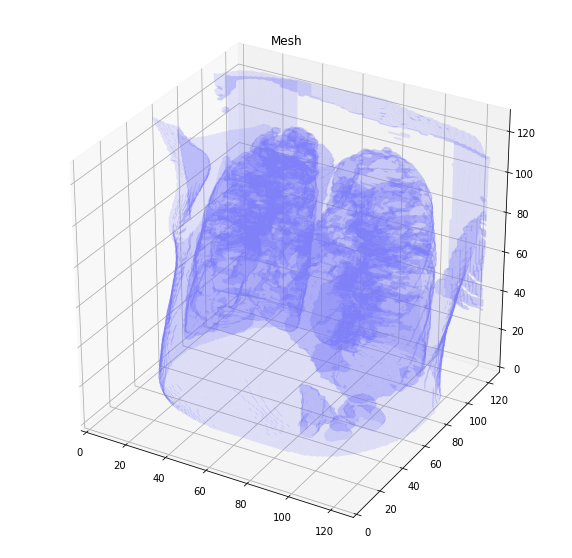

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology

def plot_mask(mask):
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection = '3d')
    
    p = mask.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p)
    mesh = Poly3DCollection(verts[faces], alpha = 0.2)
    mesh.set_facecolor((0.5, 0.5, 1))
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    plt.title("Mesh")
    plt.show()
    
plot_mask(resampled)

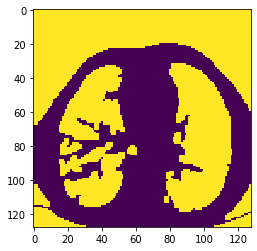

In [27]:
sample_slice = resampled[64]
plt.imshow(sample_slice)
plt.show()

In [33]:
contours, hierarchy = cv.findContours(sample_slice, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# create hull array for convex hull points

hull = []
for i in range(len(contours)):
    # creating convex hull object for each contour
    hull.append(cv.convexHull(contours[i], False))


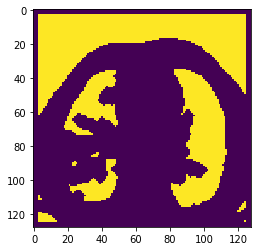

In [36]:
cv.drawContours(sample_slice, contours, -1, (0,255,0), 3)
plt.imshow(sample_slice)

In [34]:
drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)

# draw contours and hull points
for i in range(len(contours)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
    cv.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
    # draw ith convex hull object
    cv.drawContours(drawing, hull, i, color, 1, 8)